# Differentiable programming for particle physics simulations
#### Roland Grinis - CTO at GrinisRIT (grinisrit.com), Researcher at MIPT Nuclear Physics Methods lab

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Bayesian computation algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

## Introduction
In this workshop we will explore the challenges and opportunities that arise in integrating `automatic differentiation (AD)` platforms with simulations in particle physics. 

It is well known that the main drivers of success behind deep learning were the powerful `AD` engines such as [TensorFlow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/). Since then, those technologies grew up into full-fledged `differentiable programming (DP)` frameworks capable of tackling a more diversified set of tasks. 

Recently, a very fruitful interaction between `DP`, as we know it in machine learning, and numerical solutions to differential equations started to gather pace. We shall mention here the packages [torchdiffeq](https://github.com/rtqichen/torchdiffeq) and [diffeqflux](https://diffeqflux.sciml.ai/dev/) developed respectively by:

* R. Chen et al., *Neural ordinary differential equations*, Advances in Neural Information Processing Systems (2018)
* C. Rackauckus et al., *Universal differential equations for scientific machine learning*, arXiv preprint arXiv:2001.04385 (2020)

On one hand, we obtain a more flexible framework with a wealth of new tools to tackle a variety of `inverse problems`. On the other hand, many techniques such as the `adjoint sensitivity methods` gave rise to whole new powerful algorithms for `AD`. 

Unsurprisingly, one can find some roots of this story in computational finance as well, see for example:

* M. Giles et al., *Algorithmic Differentiation: Adjoint Greeks Made Easy*. SSRN Electronic Journal (2011)

But in particle physics simulations, a similar picture is left almost unexplored so far. The dynamics are richer than the ones considered before, but we also have more tools at our disposal, such as the `Backward Monte-Carlo` techniques for example. We will give an overview of the theoretical background behind those ideas and provide code examples.

## Installation

The `conda` environment provided with the repository has all the required dependencies. For this particular tutorial we will need the following `python` packages:

In [1]:
import torch
from torch.utils.cpp_extension import load
import torch.autograd
import matplotlib.pyplot as plt
%matplotlib inline

If you prefer dark plots you can run:

In [2]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

Now we need to build and load `C++17/CUDA` extensions for `PyTorch`, set up the locations:

In [3]:
!mkdir -p build
noa_location = '../..'

If you are running this on Google Colab, you need to clone `NOA` and set `noa_location` accordingly:
```python
!git clone https://github.com/grinisrit/noa.git
noa_location = 'noa'
```

Also, make sure that `ninja` and `g++-8` or higher are available. The following commands will do that for you:
```python
!pip install Ninja
!apt install gcc-8 g++-8 -y
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-8 1000
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-8 1000
!gcc --version
!g++ --version
!nvcc --version
```
Finally, you get the extensions into `python` by calling `load`:

In [141]:
diffpms = load(name='diffpms',
             build_directory='./build',
             sources=[f'{noa_location}/docs/pms/diffpms.cc'],
             extra_include_paths=[f'{noa_location}/include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_ldflags=['-lstdc++fs'],
             verbose=False)

In [5]:
diffpms_cuda = load(name='diffpms_cuda',
             build_directory='./build',       
             sources=[f'{noa_location}/docs/pms/diffpms.cu'],
             extra_include_paths=[f'{noa_location}/include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_cuda_cflags=['-std=c++17 --extended-lambda'],
             extra_ldflags=['-lstdc++fs'],
             verbose=False) if torch.cuda.is_available() else None

## Backward Monte-Carlo 

This Monte-Carlo technique seeks to reverse the simulation flow from a given final state up to a distribution of initial states. 

Several implementations have been considered, including space radiation problems and more recently muons:

* L. Desorgher et al., *Implementation of the reverse/adjoint Monte Carlo method into Geant4*, Nucl. Instrum. Meth. (2010)
* V. Niess et al., *Backward Monte-Carlo applied to muon transport*, Comput. Phys. Comm. (2018)

The latter is backed by a `C99` muon transport library [PUMAS](https://github.com/niess/pumas). In fact, the need for a `BMC` approach arises naturally in many problems from `muography`:

<img src="muography.png" />

Image credits: Z. X. Zhang et al., *Muography and Its Potential Applications to Mining and Rock Engineering*, Rock Mechanics and Rock Engineering 53, 4893-4907, (2020)

Note: if you are on Google Colab the image is located at `noa/docs/pms/muography.png`

The simulation flow:
\begin{equation}
\textbf{S}_f = \varphi(\textbf{S}_i; \textbf{X})
\end{equation}

maps an initial distribution of states $\textbf{S}_i$ to final one $\textbf{S}_f$, given an auxiliary random variable $\textbf{X}$. The state typically includes position coordinates, momentum direction and kinetic energy.

The flow $\varphi$ induces a transition distribution $\tau$ which one can use to compute the stationary flux of particles:
\begin{equation}
\phi(\textbf{s}_f) = \int \tau(\textbf{s}_f; \textbf{s}_i) \phi(\textbf{s}_i)d\textbf{s}_i
\end{equation}

at a given final state $\textbf{s}_f$. Backward Monte-Carlo is the art and science for evaluating the above integral.  

In fact, if the map $\varphi$ is invertible, one can estimate:
\begin{equation}
\phi(\textbf{s}_f) \simeq \frac{1}{N} \sum_{k=1}^N \omega_{k} \phi(\textbf{s}_{i,k})
\end{equation}

where $\textbf{s}_{i,k} = \varphi^{-1}(\textbf{s}_f; x_k)$ for a draw $x_k \sim \textbf{X}$ and:
\begin{equation}
\omega_{k} = det(\nabla_{\textbf{s}_f}\varphi^{-1})|_{x_k}
\end{equation}


In practice, the flow $\varphi$ is broken down into a sequence of $n$ steps:
\begin{equation}
\textbf{s}_{0,k} = \varphi_1^{-1} \circ \varphi_2^{-1} \circ \dots \circ \varphi_n^{-1} (\textbf{s}_n; x_{n,k})
\end{equation}

and so we get:
\begin{equation}
\omega_{k} = \prod_{j=1}^{n}det(\nabla_{\textbf{s}_j}\varphi_j^{-1})|_{x_{j,k}}
\end{equation}

Unfortunately, the simulation flow is not always invertible and one has to rely on `biasing techniques`. In such situation, we need to construct a regularised version $\varphi_{b}$ of the flow, together with its transition density  $\tau_b$. Then, provided the Radon–Nikodym derivative of $\tau$ exists we can set: 
\begin{equation}
\omega_{k} = \frac{\tau(\textbf{s}_f; \textbf{s}_i)}{\tau_b(\textbf{s}_f; \textbf{s}_i)} det(\nabla_{\textbf{s}_f}\varphi_b^{-1})|_{x_k}
\end{equation}

where the initial state is obtained as $\textbf{s}_{i,k} = \varphi_b^{-1}(\textbf{s}_f; x_k)$.

Of special interest to us is the case of mixture densities:
\begin{equation}
\tau(\textbf{s}_f; \textbf{s}_i) = \sum_{\ell=1}^{m} p_{\ell}(\textbf{s}_i) \tau_{\ell}(\textbf{s}_f; \textbf{s}_i) 
\end{equation}

for a partition of unity of the state space $\sum_{{\ell}=1}^{m} p_{\ell} \equiv 1$. 

On has to construct an apriori partition of unity $\sum_{\ell=1}^{m} p_{\ell, b} \equiv 1$. It is used to choose the component $\ell_0$ to evolve with the flow backwards, giving:
\begin{equation}
\omega_{k} = \frac{p_{\ell_0}(\textbf{s}_i)\tau_{\ell_0}(\textbf{s}_f; \textbf{s}_i)}{p_{\ell_0,b}(\textbf{s}_f)\tau_{\ell_0, b}(\textbf{s}_f; \textbf{s}_i)} det(\nabla_{\textbf{s}_f}\varphi_{\ell_0,b}^{-1})|_{x_{\ell_0,k}} 
\end{equation}

and $\textbf{s}_{i,k} = \varphi_{\ell_0,b}^{-1}(\textbf{s}_f; x_k)$.

In [46]:
knode = torch.tensor([0.,5., 10.])
detector =  torch.zeros(2)

In [6]:
def level_set(t, node, x):
    zz02 = (-node[2] * torch.log(t)) - (x - node[0]).pow(2)
    zz0 =  torch.sqrt(zz02[zz02 > 0])
    xs = x[zz02 > 0]
    zs = node[1] - zz0
    return xs, zs

def plot_detector(detector, node_param, x = torch.linspace(-5., 5., 500)):
    plt.figure(figsize=(20,10))

    for t in torch.linspace(0.01,0.99, 50):
        xs, zs = level_set(t, node_param, x)
        plt.plot(xs.numpy(), zs.numpy(), 'C1',alpha=.5 + 0.5*t.item())

    plt.plot(detector[0].numpy(), detector[1].numpy(), '.C3',markersize=50, label='detector',alpha=0.9)
    
    plt.legend(fontsize=20)
    plt.xlim([-5.,5.]) 
    plt.ylim([-1.,4.5])

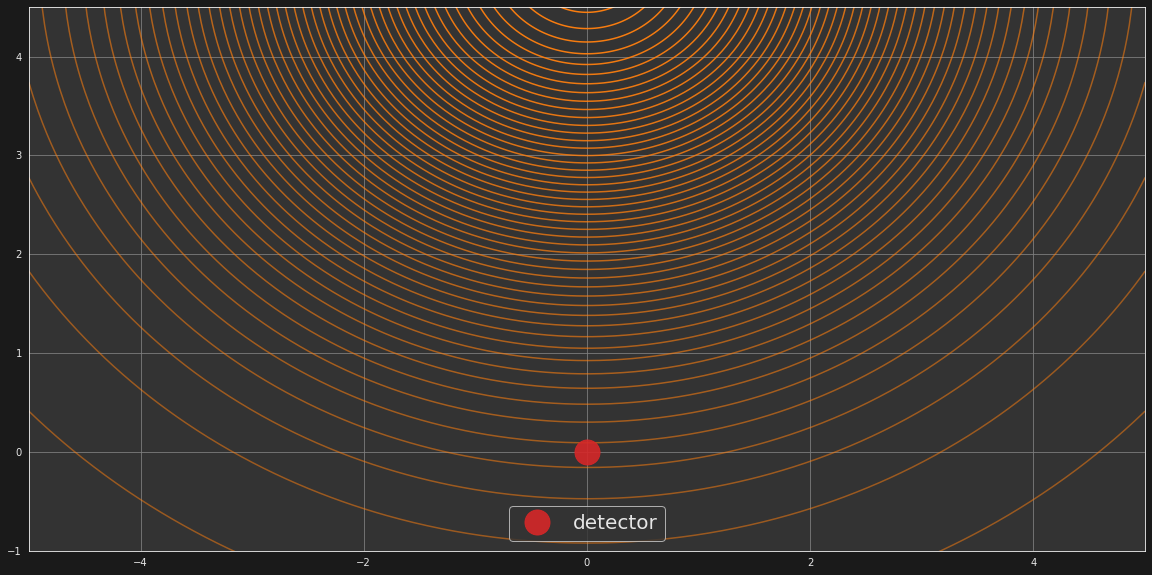

In [7]:
plot_detector(detector, knode)

In [8]:
PI = 2 * torch.acos(torch.tensor(0.))
thetas = PI * torch.tensor([0.0, 0.1, -0.08]) 

In [9]:
def mix_density(states, node):
    return torch.exp(-(states - node[:2]).pow(2).sum(-1) / node[2].abs())

In [10]:
bmcs = []
for theta in thetas:
    bmcs.append(diffpms.backward_mc(theta, knode, 10)[1])

In [11]:
def plot_particles(bmc):
    for particle in bmc:
        plt.plot(particle[-1][0].numpy(), particle[-1][1].numpy(), '.C0',markersize=30, alpha=0.6)
        trajectory = torch.cat([detector.reshape(1,2), particle]).T
        plt.plot(trajectory[0].numpy(),trajectory[1].numpy(), 'C0', alpha=0.9) 
        
def plot_bmc(bmc_data, detector, node_param):
    plot_detector(detector, node_param)
    for bmc in bmc_data:
        plot_particles(bmc)

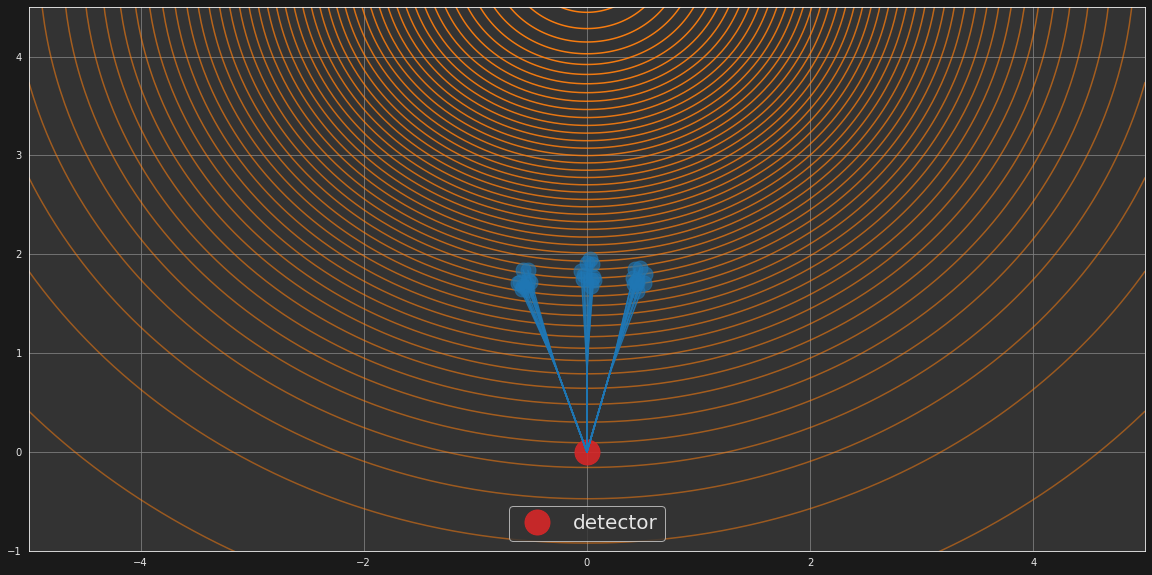

In [12]:
plot_bmc(bmcs, detector, knode)

In [13]:
for theta in thetas:
    flux, _ = diffpms.backward_mc(theta, knode, 100000)
    print(f'Flux at {round(theta.item(),2)}: {round(flux.mean().item(),6)}')

Flux at 0.0: 0.048538
Flux at 0.31: 0.042626
Flux at -0.25: 0.044999


## Differentiable Programming

In [21]:
for theta in thetas:
    flux = diffpms.backward_mc(theta, torch.tensor([-1.0, 5.0, 10.0]), 100000)[0].mean()
    print(f'Flux at {round(theta.item(),2)}: {round(flux.item(),6)}')

Flux at 0.0: 0.040044
Flux at 0.31: 0.041542
Flux at -0.25: 0.032373


In [22]:
observed_flux = torch.tensor([0.04, 0.042, 0.032])

In [26]:
rng = list(range(1000,100000,1000))
log_prob, log_prob_grad = diffpms.grad_convergence_test(knode, thetas, observed_flux, 1000.0, knode, 1.0, list(range(1000,100000,1000)))

In [27]:
print( f'Log probability: {round(log_prob[-1].item(),6)} ~ {round(log_prob[-30:].std().item(),3)}')
print( f'Log probability: {log_prob_grad[-1]} ~ {log_prob_grad[-30:].std(0)}')

Log probability: -0.115186 ~ 0.004
Log probability: tensor([-0.0679,  1.4019, -0.2623]) ~ tensor([0.0024, 0.0351, 0.0066])


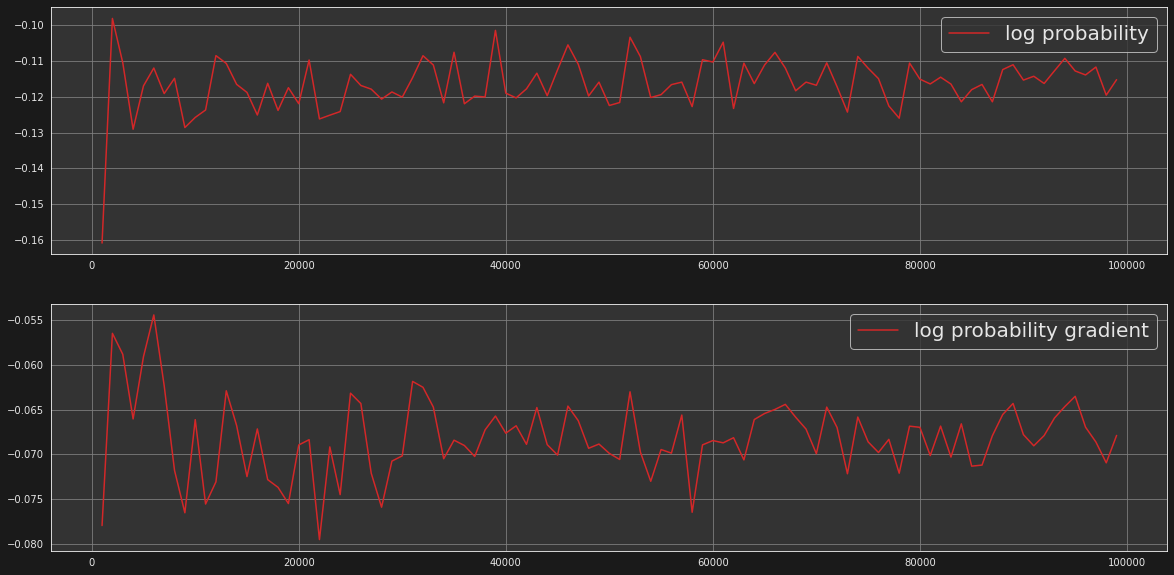

In [39]:
fig, axs = plt.subplots(2, figsize=(20,10));
axs[0].plot(torch.tensor(rng).numpy(), log_prob.numpy(), 'C3', label='log probability',alpha=0.99);
axs[0].legend(fontsize=20);
axs[1].plot(torch.tensor(rng).numpy(), log_prob_grad[:,0].numpy(), 'C3', label='log probability gradient',alpha=0.99);
axs[1].legend(fontsize=20);

In [74]:
N = 1001
log_val, log_flow = diffpms.gradient_descent_bmc(thetas[1:], observed_flux[1:], knode, N) 

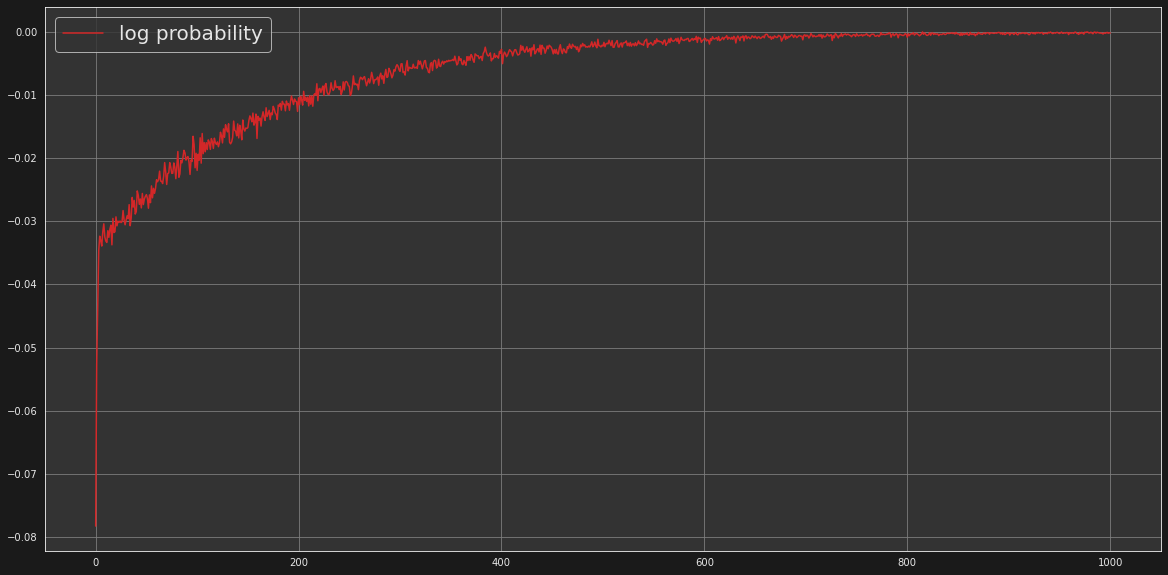

In [75]:
plt.figure(figsize=(20,10))
plt.plot(torch.arange(N).numpy(), log_val.numpy(), 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

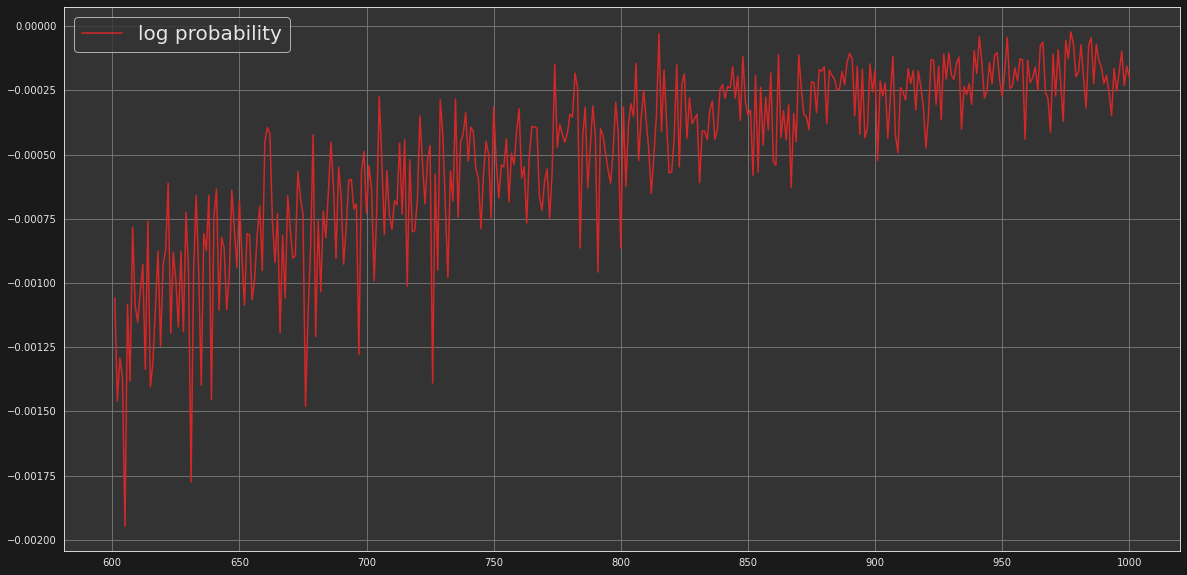

In [76]:
plt.figure(figsize=(20,10))
plt.plot(torch.arange(N).numpy()[-400:], log_val.numpy()[-400:], 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

In [77]:
optimal_node = log_flow[-200:].mean(0)
optimal_node

tensor([-1.0013,  4.9896,  9.9613])

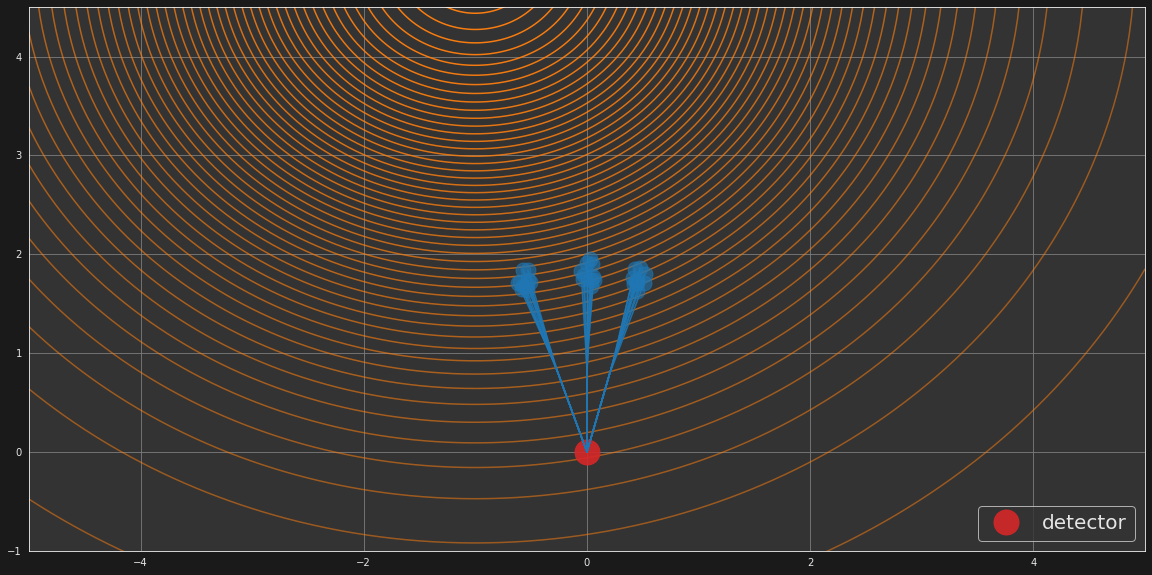

In [79]:
plot_bmc(bmcs, detector, optimal_node)

In [116]:
samples = diffpms.bayesian_backward_mc(thetas[:1], observed_flux[:1], 100.0, optimal_node, 1.0, 100000, 30, 10, 0.001, 0.0001, 10.0)
samples.shape

torch.Size([301, 3])

In [120]:
print(f'Sample mean: {samples.mean(0)}')
print(f'Sample std: {samples.std(0, True)}')

Sample mean: tensor([-1.0051,  4.9894,  9.9908])
Sample std: tensor([0.0149, 0.0106, 0.0208])


## Adjoint sensitivity method

Consider an ODE: 
\begin{equation}
\frac{dx}{dt} = f(t, x(t), \theta)
\end{equation}

and imagine that we want to compute the gradient of some scalar function:
\begin{equation}
\mathcal{L}(x(t_1)) = \mathcal{L} \left( x(t_0) + \int_{t_0}^{t_1}f(t, x(t), \theta)dt\right)
\end{equation}

with respect to the parameters $\theta$. 

An efficient way to tackle this task is to introduce the adjoint:
\begin{equation}
a(t) =  \nabla_{x(t)}\mathcal{L}
\end{equation}

which satisfies the adjoint ODE:
\begin{equation}
\frac{da}{dt} = - a(t) \cdot \nabla_x f(t, x(t), \theta)
\end{equation}

The desired gradient is given then by a backward in time integral:
\begin{equation}
\nabla_{\theta}\mathcal{L} = - \int_{t_1}^{t_0} a(t) \cdot \nabla_{\theta} f(t, x(t), \theta)dt
\end{equation}

Reference: L. S. Pontryagin et al., *The mathematical theory of optimal processes* (1962)

In [164]:
torch.manual_seed(10)
diffpms.backward_mc_grad(thetas[0], knode)

(tensor([0.0042]), tensor([ 8.2982e-06, -1.8718e-03,  4.5535e-04]))

## Tensor Operations

In [34]:
kinetic_energies = torch.linspace(1e-3, 1e6, 10000).double()
recoil_energies = 0.0505 * kinetic_energies

In [35]:
kinetic_energies_gpu = kinetic_energies.cuda()
recoil_energies_gpu = recoil_energies.cuda()

In [36]:
kinetic_energies_gpu[:5]

tensor([1.0000e-03, 1.0001e+02, 2.0002e+02, 3.0003e+02, 4.0004e+02],
       device='cuda:0', dtype=torch.float64)

In [37]:
brems_gpu = diffpms_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);
brems_gpu[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       device='cuda:0', dtype=torch.float64)

In [38]:
brems = diffpms.bremsstrahlung(kinetic_energies, recoil_energies)
brems[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       dtype=torch.float64)

In [39]:
%timeit diffpms_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);

156 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [40]:
%timeit diffpms.bremsstrahlung(kinetic_energies, recoil_energies);

312 µs ± 2.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
diffpms.serialise(brems, 'brems.pt')

In [42]:
brems_pt = next(torch.jit.load('brems.pt').parameters())
brems_pt[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       dtype=torch.float64)